<a href="https://colab.research.google.com/github/as2092/Sentiment-Analysis/blob/master/SentimentAnalysis_ULMFiT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, I'll be using Transfer learning for Sentiment Analysis on US Airline Data

# ULMFit Model<br>
Transfer learning means training a model for one task and then utilize this knowledge to train some other model. This technique becomes more useful when there is less labelled data. ULMFiT is based on Transfer learning with condition:<br>


1.   The source task has to be different from target task
2.   Labelled data should be available for taget task

<br>
In our case , the source task is a language model(LM) and target task is a Classifier for sentiment Analysis.<br>
<br>
ULMFiT training consists of three stages:


1.   Training the language model on a general-domain corpus that captures high-level natural language features
2.   Fine-tuning the pre-trained language model on target task data 
3.   Fine-tuning the classifier on target task data












# Implementation using FastAi



In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
# import the libraries
from fastai.text import *
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



# Getting the Data from Kaggle

In [3]:
!pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)


In [0]:
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
path = Config.data_path()/'airlines'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/airlines')

In [9]:
! kaggle datasets download -d crowdflower/twitter-airline-sentiment -f Tweets.csv -p {path}

  0% 0.00/1.08M [00:00<?, ?B/s]
100% 1.08M/1.08M [00:00<00:00, 73.5MB/s]


In [0]:
! unzip -q -n {path}/Tweets.csv.zip -d {path}

In [0]:
# get the data into a dataframe
df = pd.read_csv(path/'Tweets.csv')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
tweet_id                        14640 non-null int64
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason_confidence       10522 non-null float64
airline                         14640 non-null object
airline_sentiment_gold          40 non-null object
name                            14640 non-null object
negativereason_gold             32 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1019 non-null object
tweet_created                   14640 non-null object
tweet_location                  9907 non-null object
user_timezone                   9820 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.7+ MB


In [0]:
# only two columns are relevant for our task
new_df=df[['text', 'airline_sentiment']]

In [19]:
new_df = new_df.rename(index = str, columns = {"airline_sentiment" : "label"})
new_df.head()

,text,label
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


# test/train split

In [0]:
test_percentage = 0.1
new_df.sort_index(inplace=True)
cutoff = int(test_percentage * new_df.shape[0])
new_df[['label', 'text']][:cutoff].to_csv(path/'Tweets_test.csv', index=False, encoding='utf-8')
new_df[['label', 'text']][cutoff:].to_csv(path/'Tweets_train.csv', index=False, encoding='utf-8')
new_df[['text']][cutoff:].to_csv(path/'Tweets_text_only_train.csv', index=False, encoding='utf-8')

In [21]:
# check if any missing values are present
new_df.isnull().values.any()

False

In [22]:
# create a data bunch (it will take care of creation of vocab)
data = TextClasDataBunch.from_csv(path, 'Tweets_train.csv')
data.show_batch()

text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup dub 13 / 10 . i 'm * xxup g. xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
xxbos @usairways xxup plans xxup changed ! xxup is xxup that xxup what u xxup call xxup not xxup xxunk xxup able 2 xxup park xxup on xxup time xxup planes w a 2 xxup hr xxup layover n b xxup able 2 xxup make xxup ur xxup connection ! # seriously,negative
xxbos @americanair xxmaj hi . i have xxup koa - xxup lax - xxup phl - xxup ord booked as a 1-way xxunk xxunk . xxmaj if i called to chnge it to xxup koa - xxup lax - xxup phx - xxup ord would i have to pay any fees,neutral
xxbos @virginamerica xxmaj many xxmaj thanks for the xxmaj follow . \n # xxunk # xxunk # xxup usa # xxmaj xxunk \n xxmaj looking for xxmaj any xxmaj help 😍 \n 💗 xxunk xxunk 💗 🇺 🇸 💗 \n 🎀 🌏 🎀 http : / / t.co / xxunk,neutral
"xxbos @jetblue i ❤ ️ xxmaj jetblue but i was on flt xxunk from fll to sfo . xxunk off was over 1 hr xxmaj late xxmaj flight , div to phx & & got in 2 hrs xxmaj late xxmaj flight . xxmaj what will be done ?",negative


In [23]:
# checking words mapped to first 5 indexes in vocabulary
data.vocab.itos[:5]

['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld']

In [24]:
# check a training example
data.train_ds[0][0]

Text xxbos @southwestair i do n't have a conference number . i spoke with xxmaj xxunk in xxmaj texas and xxmaj david before that . they finally fixed mine after an hour

In [25]:
# integer fom of the training example
data.train_ds[0][0].data[:10]

array([   2,   28,   11,   47,   33,   39,   15, 1744,  184,    9])

# Language Model


*   Using Language Model pre-trained on WikiText-103 by Fast.AI, We'll just fine tune it using unlabelled samples of our airlines dataset.




In [0]:
# batch size
bs = 24

In [56]:
# using unlabelled dataset for finetuning the language model
data_lm = (TextList.from_csv(path, 'Tweets_text_only_train.csv')
           .split_by_rand_pct(0.1, seed = 42)
           #We randomly split and keep 10% (10,000 reviews) for validation
           .label_for_lm()           
           #We want to do a language model so we label accordingly
           .databunch(bs=bs))
data_lm.save('data_lm.pkl')

In [0]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [29]:
data_lm.show_batch()

idx,text
0,"@usairways xxmaj your software is broken . "" xxmaj call xxmaj customer xxmaj support "" is not the fix . xxmaj like i said earlier , yell at your xxunk . xxbos @usairways xxmaj it 's not double booked . i spoke with xxup cs and we 've got a plan to fix this . xxmaj it 's still an xxunk mistake that should never happen . xxbos @usairways is"
1,"xxmaj flightations , i have driven to 3 airports in 3 different states , spent more on gas than my flight . xxbos @usairways then why did my whole team be able to put there carry ons under the plane xxbos @usairways xxmaj no xxunk email . 1500 xxunk limit for complaints . xxmaj is xxup aa / xxup us customer complaints adopting the twitter model ? xxbos @usairways please"
2,"anyone help me with this ? xxbos @americanair my xxunk is :) xxbos @americanair sitting on plane in xxmaj columbus , supposed to leave an hour ago . xxmaj now the xxunk ca n't find a tool to service the shock xxunk . xxbos @americanair xxmaj not here yet , but i plan on it . xxmaj if you could have them fly low and slow right in front of"
3,"run their account how embarrassing for you xxbos @americanair xxup tsa said there is nothing they could do . xxmaj but the question is why are your employee 's xxunk your customers belongings ? xxbos @americanair now i have to wait "" more than 60 minutes "" xxbos @americanair thanks , me too xxbos @united how is it that i book a flight with a reserved seat and then go"
4,"i 'm trying to change is in 4 hours and i 've been trying to reach an agent for 72 now . xxup this xxup is xxup unbelievable . xxbos @americanair xxmaj why is it ok that no - one can help me with the bag you lost on my honeymoon xxunk ago , this is not responsible or professional xxbos @americanair xxup xxunk . xxmaj after the fourth time"


In [30]:
# load the model to the learner (using AWD_LSTM implemented by FAST.AI)
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult = 0.3)

In [31]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


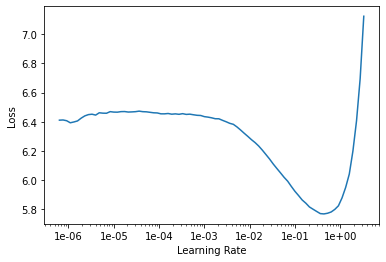

In [32]:
# finding the learning rate to be used further
learn.recorder.plot(skip=15)

In [33]:
learn.fit_one_cycle(1, 1e-1, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.335048,3.969304,0.263423,00:12


In [0]:
learn.save('fit_head')

In [35]:
learn.load('fit_head')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (11859 items)
x: LMTextList
xxbos @usairways shout out to the pilots and xxup fc xxunk ) of xxup us xxunk . xxmaj super strong xxunk during landing . xxmaj xxunk did a super job throughout,xxbos @usairways now telling me i do n't have the correct tag for my luggage ! ! ! xxmaj my luggage apparently is not in xxup la or xxmaj charlotte . xxmaj this is not ok ! !,xxbos @usairways xxmaj your software is broken . " xxmaj call xxmaj customer xxmaj support " is not the fix . xxmaj like i said earlier , yell at your xxunk .,xxbos @usairways xxmaj it 's not double booked . i spoke with xxup cs and we 've got a plan to fix this . xxmaj it 's still an xxunk mistake that should never happen .,xxbos @usairways is there nothing that can be done online to help ? i bought these as a birthday present , just trying to be able to afford a change
y: LMLabelList
,,,,
Path: /root/.fastai/data/airlines;

Valid: LabelList (1317 items)
x: LMTextList
xxbo

# Fine Tuning<br>

In [0]:
learn.unfreeze()

In [37]:
learn.fit_one_cycle(10, 1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.728808,3.801443,0.279702,00:12
1,3.672542,3.781676,0.277827,00:12
2,3.588810,3.752174,0.282530,00:12
3,3.460372,3.734493,0.287470,00:12
4,3.203606,3.784338,0.285565,00:12
5,2.866232,3.843366,0.286696,00:12
6,2.369111,4.011882,0.283839,00:12
7,1.856923,4.221107,0.279286,00:12
8,1.472925,4.389052,0.278839,00:12
9,1.307344,4.451264,0.278601,00:12


In [0]:
learn.save('fine_tuned')

In [0]:
learn.save_encoder('fine_tuned_enc')

The fine tuned language model is saved

# Classifier<br>
Adding the classifier linear layers to the model and training the classifier on labelled data

In [40]:
# Classifier databunch
data_clas = (TextList.from_csv(path, 'Tweets_train.csv', cols='text')
           .split_by_rand_pct(0.1, seed = 42)
           #We randomly split and keep 10% (10,000 reviews) for validation
           .label_from_df(cols=0)           
           .databunch(bs=bs))
data_clas.save('data_clas.pkl')

In [41]:
data_clas.show_batch()

text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac xxunk / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup dub 13 / 10 . i 'm * xxup xxunk xxmaj what is checked bag xxunk for xxup jac - xxup lax ?,neutral
"xxbos @jetblue i ❤ ️ xxmaj jetblue but i was on flt xxunk from fll to sfo . xxunk off was over 1 hr xxmaj late xxmaj flight , div to phx & & got in 2 hrs xxmaj late xxmaj flight . xxmaj what will be done ?",negative
xxbos @americanair xxup poor xxup experience 2day at ord xxunk . 8 xxunk . w / 3 cust . 10 waiting . xxmaj asked to speak w / supervisor . xxmaj told 20 min . xxmaj in a mtg ! ! xxmaj what ? ! ? !,negative
xxbos @united xxunk 7 xxup weeks xxmaj late flightr xxup and i xxup still xxup have xxup not xxup received xxup my xxup miles xxup from xxup the mileageplus xxmaj gift xxmaj card $ 150 xxup xxunk xxup card i xxup handed xxup over ! ! !,negative
xxbos @americanair xxmaj took a flight yesterday xxunk xxup tpa - xxup dfw - xxup aus . xxmaj bag went to xxup iah . xxmaj today bag went to xxup iah - xxup dfw and then back to xxup iah . xxmaj still no bag !,negative


In [42]:
# Classifier learner
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (11859 items)
x: TextList
xxbos @usairways shout out to the pilots and xxup fc xxunk ) of xxup us xxunk . xxmaj super strong xxunk during landing . xxmaj xxunk did a super job throughout,xxbos @usairways now telling me i do n't have the correct tag for my luggage ! ! ! xxmaj my luggage apparently is not in xxup la or xxmaj charlotte . xxmaj this is not ok ! !,xxbos @usairways xxmaj your software is broken . " xxmaj call xxmaj customer xxmaj support " is not the fix . xxmaj like i said earlier , yell at your xxunk .,xxbos @usairways xxmaj it 's not double booked . i spoke with xxup cs and we 've got a plan to fix this . xxmaj it 's still an xxunk mistake that should never happen .,xxbos @usairways is there nothing that can be done online to help ? i bought these as a birthday present , just trying to be able to afford a change
y: CategoryList
positive,negative,negative,negative,neutral
Path: /root/.fastai/data/airlines;

Valid: LabelL

In [43]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


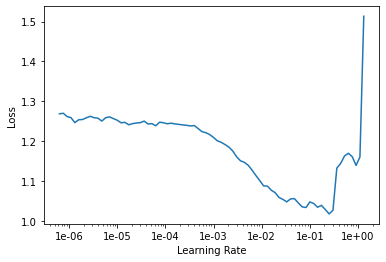

In [44]:
learn.recorder.plot()

In [45]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.683958,0.569562,0.766894,00:14


In [0]:
learn.save('first')

In [47]:
learn.load('first')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (11859 items)
x: TextList
xxbos @usairways shout out to the pilots and xxup fc xxunk ) of xxup us xxunk . xxmaj super strong xxunk during landing . xxmaj xxunk did a super job throughout,xxbos @usairways now telling me i do n't have the correct tag for my luggage ! ! ! xxmaj my luggage apparently is not in xxup la or xxmaj charlotte . xxmaj this is not ok ! !,xxbos @usairways xxmaj your software is broken . " xxmaj call xxmaj customer xxmaj support " is not the fix . xxmaj like i said earlier , yell at your xxunk .,xxbos @usairways xxmaj it 's not double booked . i spoke with xxup cs and we 've got a plan to fix this . xxmaj it 's still an xxunk mistake that should never happen .,xxbos @usairways is there nothing that can be done online to help ? i bought these as a birthday present , just trying to be able to afford a change
y: CategoryList
positive,negative,negative,negative,neutral
Path: /root/.fastai/data/airlines;

Valid: LabelL

In [48]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.638336,0.518047,0.788155,00:15


In [0]:
learn.save('second')

In [50]:
learn.load('second')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (11859 items)
x: TextList
xxbos @usairways shout out to the pilots and xxup fc xxunk ) of xxup us xxunk . xxmaj super strong xxunk during landing . xxmaj xxunk did a super job throughout,xxbos @usairways now telling me i do n't have the correct tag for my luggage ! ! ! xxmaj my luggage apparently is not in xxup la or xxmaj charlotte . xxmaj this is not ok ! !,xxbos @usairways xxmaj your software is broken . " xxmaj call xxmaj customer xxmaj support " is not the fix . xxmaj like i said earlier , yell at your xxunk .,xxbos @usairways xxmaj it 's not double booked . i spoke with xxup cs and we 've got a plan to fix this . xxmaj it 's still an xxunk mistake that should never happen .,xxbos @usairways is there nothing that can be done online to help ? i bought these as a birthday present , just trying to be able to afford a change
y: CategoryList
positive,negative,negative,negative,neutral
Path: /root/.fastai/data/airlines;

Valid: LabelL

In [0]:
learn.unfreeze()

In [55]:
learn.fit_one_cycle(8, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.493563,0.491373,0.800304,00:17
1,0.481050,0.490090,0.801822,00:16
2,0.438624,0.487888,0.807137,00:15
3,0.451962,0.494483,0.803341,00:16
4,0.383727,0.493298,0.800304,00:15
5,0.383645,0.497697,0.798785,00:16
6,0.400374,0.506454,0.800304,00:17
7,0.373226,0.511292,0.801063,00:15


The validation accuracy is around 80% which is better than using pre-trained embedding (Glove)

In [54]:
learn.predict("It was good experience")

(Category positive, tensor(2), tensor([0.0659, 0.0567, 0.8774]))